In [577]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

In [212]:
%matplotlib notebook

### load prepared data

In [213]:
df = pd.read_csv('Datasets/user_df_31k.csv')
df_norm = pd.read_csv('Datasets/user_df_31k_normalized.csv')

In [214]:
df_norm

,index,ip,user_agent,request_count,crawled_rate_avg,Head_request_avg,url_anomaly_rate_avg,url_path_depth_avg,image_request_avg,code_request_avg,...,app_request_avg,4xx_avg,3xx_avg,response_length_bin_avg,response_time_bin_avg,response_length_avg,response_time_avg,response_length_bin_std,response_time_bin_std,is_bot
0,2,1.81.122.235,Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like M...,-0.169094,-0.843458,-0.033295,-1.212739,1.131311,-1.847961,-1.363019,...,-0.037714,-0.216560,-0.155641,3.415990,0.759361,1.114331,-0.196834,-2.259758,1.172881,-0.314785
1,3,10.92.2.8,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,-0.046097,0.348883,-0.033295,-1.212739,0.110638,0.089661,-0.372054,...,-0.037714,-0.216560,-0.155641,1.449394,-0.262510,0.252873,-0.197244,-0.013607,0.380420,-0.314785
2,4,100.92.35.41,Mozilla/5.0 (Linux; Android 9; SM-A205F) Apple...,-0.139809,-0.997329,-0.033295,1.191030,0.513867,-1.847961,0.949233,...,-0.037714,-0.216560,-0.155641,1.036651,-0.338204,0.999059,-0.197221,2.392406,0.285509,-0.314785
3,6,102.0.232.185,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,-0.116381,-0.770215,-0.033295,3.594799,1.660549,-1.847961,-1.363019,...,-0.037714,-0.216560,-0.155641,-0.662876,4.165597,-0.429797,1.886087,-2.259758,4.835281,-0.314785
4,7,102.0.232.220,Mozilla/5.0 (Linux; Android 11; SM-A505F) Appl...,-0.128095,2.594769,-0.033295,-1.212739,-0.834430,0.574066,1.114394,...,-0.037714,-0.216560,-0.155641,1.813578,-0.603134,0.376562,-0.197517,-0.599849,-0.756449,-0.314785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33341,51067,99.239.78.14,Mozilla/5.0 (MSIE 10.0; Windows NT 6.1; WOW64;...,-0.169094,-1.121644,-0.033295,-0.182553,-0.834430,0.089661,-0.372054,...,-0.037714,6.756189,-0.155641,1.959252,-0.148969,0.276060,-0.197021,-0.357636,0.607794,-0.314785
33342,51068,99.239.78.14,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,-0.128095,-1.022693,-0.033295,-1.212739,-0.834430,0.574066,1.114394,...,-0.037714,-0.216560,-0.155641,-2.410962,-0.603134,-0.378877,-0.197697,-0.176087,-0.756449,-0.314785
33343,51069,99.239.78.14,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,-0.081239,-1.177284,-0.033295,-1.212739,-0.600740,1.234619,0.213516,...,-0.037714,-0.216560,-0.155641,1.561960,-0.603134,0.185398,-0.197651,-0.597564,-0.756449,-0.314785
33344,51070,99.239.78.14,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,-0.087096,-0.862995,-0.033295,-1.212739,-0.683219,1.381409,0.288589,...,-0.037714,-0.216560,-0.155641,1.570789,-0.603134,0.200975,-0.197673,-0.558448,-0.756449,-0.314785


## BASE MODELS
---
>### 1. IF (IsolationForest)



In [264]:
if_df = df.copy()
X = df_norm.iloc[:,3:]
X.drop(columns=['response_length_avg' ,'response_time_avg'], inplace=True)

In [265]:
if_model = IsolationForest(n_estimators=120, max_samples='auto', contamination=0.1, random_state=42)

if_model.fit(X)

anomaly_scores = if_model.decision_function(X)
predictions = if_model.predict(X)
anomalies = X[predictions == -1]



# Add anomaly scores to the DataFrame for further analysis
if_df['anomaly_score'] = anomaly_scores
if_df['anomaly'] = np.where(predictions==-1, True, False)



# Summary of anomalies
print(f"Number of anomalies: {len(anomalies)}")
print(f"Total instances: {len(X)}")
print(f"Anomaly percentage: {len(anomalies) / len(X) * 100:.2f}%")


Number of anomalies: 3335
Total instances: 33346
Anomaly percentage: 10.00%


In [266]:
is_bot = if_df[if_df['is_bot'] == 1]

bot_anomaly_count = len(is_bot[is_bot['anomaly'] == True])
bot_non_anomaly_count = len(is_bot[is_bot['anomaly'] == False])

# Print the results
print("Number of anomalies with is_bot:", bot_anomaly_count)
print("Number of non-anomalies with is_bot:", bot_non_anomaly_count)

Number of anomalies with is_bot: 668
Number of non-anomalies with is_bot: 1


In [267]:
anomalies

,request_count,crawled_rate_avg,Head_request_avg,url_anomaly_rate_avg,url_path_depth_avg,image_request_avg,code_request_avg,renderable_request_avg,video_requests_avg,font_request_avg,app_request_avg,4xx_avg,3xx_avg,response_length_bin_avg,response_time_bin_avg,response_length_bin_std,response_time_bin_std,is_bot
3,-0.116381,-0.770215,-0.033295,3.594799,1.660549,-1.847961,-1.363019,-0.265273,-0.005476,-1.112346,-0.037714,-0.216560,-0.155641,-0.662876,4.165597,-2.259758,4.835281,-0.314785
9,7.509381,-0.781305,-0.033295,2.865278,1.516795,-1.503217,-1.194600,-0.157806,-0.005476,-0.965416,-0.037714,-0.198043,-0.018682,-0.506592,4.701084,-0.049851,4.579371,-0.314785
19,-0.157380,-0.293478,-0.033295,1.992286,1.013702,-0.340922,-1.363019,-0.265273,-0.005476,-1.112346,-0.037714,5.206690,-0.155641,0.470142,2.576020,0.572212,4.657720,-0.314785
24,-0.180808,-0.495664,-0.033295,1.671783,0.707921,-0.491626,-1.363019,9.177442,-0.005476,-1.112346,-0.037714,-0.216560,-0.155641,-1.478650,1.304358,1.226890,4.086131,-0.314785
28,-0.169094,-1.022693,-0.033295,3.594799,2.189787,-1.847961,-1.363019,-0.265273,-0.005476,-1.112346,-0.037714,24.188062,-0.155641,-2.702310,-0.603134,-2.259758,-0.756449,-0.314785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33281,-0.180808,2.715061,-0.033295,3.594799,2.189787,-1.847961,-1.363019,-0.265273,-0.005476,-1.112346,-0.037714,-0.216560,-0.155641,2.192330,7.026836,1.226890,1.220526,-0.314785
33290,-0.186664,0.232286,-0.033295,3.594799,1.660549,-1.847961,-1.363019,-0.265273,-0.005476,-1.112346,-0.037714,-0.216560,-0.155641,-0.662876,3.370809,-2.259758,4.657720,-0.314785
33293,-0.180808,-0.760375,-0.033295,-1.212739,-0.985641,4.933715,-1.363019,-0.265273,-0.005476,-1.112346,-0.037714,19.307138,-0.155641,1.376557,-0.603134,-2.259758,-0.756449,-0.314785
33308,-0.180808,-1.171574,-0.033295,0.710276,0.284530,0.864709,-1.363019,9.177442,-0.005476,-1.112346,-0.037714,-0.216560,-0.155641,-1.478650,1.304358,1.226890,4.086131,-0.314785


In [369]:
anomalies_df = if_df[if_df['anomaly'] == True]
anomalies_df.sort_values(['anomaly_score'], ascending=True).head(30)

,ip,user_agent,request_count,crawled_rate_avg,Head_request_avg,url_anomaly_rate_avg,url_path_depth_avg,image_request_avg,code_request_avg,renderable_request_avg,...,3xx_avg,response_length_bin_avg,response_time_bin_avg,response_length_avg,response_time_avg,response_length_bin_std,response_time_bin_std,is_bot,anomaly_score,anomaly
8364,186.236.39.213,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,313,0.436371,0.335463,0.000000,0.332268,0.000000,0.000000,0.000000,...,0.332268,0.664537,0.083067,2.105286e+04,17.801917,0.943562,0.276426,1,-0.203572,True
2945,127.227.194.30,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,4,0.775679,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,2.000000,0.000000,2.825300e+04,4.000000,0.000000,0.000000,1,-0.170095,True
30023,67.190.73.3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,4,0.677056,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,2.000000,0.000000,2.825300e+04,10.000000,0.000000,0.000000,1,-0.169994,True
22888,35.63.72.210,Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:...,4,0.619279,0.000000,0.000000,2.000000,0.000000,0.000000,0.250000,...,0.250000,1.500000,0.250000,2.229500e+04,21.000000,1.000000,0.500000,1,-0.168276,True
8368,187.171.235.37,Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:...,91,0.966754,0.000000,0.000000,2.549451,0.000000,0.000000,0.010989,...,0.186813,1.758242,0.538462,3.553490e+04,79.428571,0.910929,0.501280,1,-0.162098,True
25281,36.67.23.210,Go-http-client/2.0,7580,0.434183,0.458179,0.000000,0.886412,0.000000,0.000000,0.346570,...,0.097493,0.542084,0.023219,6.610200e+03,16.837203,0.666185,0.150608,0,-0.161780,True
15806,35.136.103.180,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,6,0.125190,0.000000,0.000000,1.500000,0.666667,0.000000,0.000000,...,0.166667,1.833333,0.166667,3.349633e+04,14.000000,0.408248,0.408248,1,-0.161473,True
30152,67.38.224.168,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,4,0.246912,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,2.000000,0.000000,2.825300e+04,2.000000,0.000000,0.000000,1,-0.160842,True
15765,35.132.136.207,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,4,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,2.000000,0.000000,2.825300e+04,8.000000,0.000000,0.000000,1,-0.159631,True
28885,60.148.0.167,Go-http-client/2.0,7346,0.432933,0.440103,0.000000,0.882657,0.000000,0.000000,0.359379,...,0.100191,0.560033,0.019058,6.788378e+03,16.418595,0.668663,0.136738,0,-0.159605,True


In [370]:
anomalies_df[anomalies_df['user_agent'].str.contains('blackberry', case=False)]


,ip,user_agent,request_count,crawled_rate_avg,Head_request_avg,url_anomaly_rate_avg,url_path_depth_avg,image_request_avg,code_request_avg,renderable_request_avg,...,3xx_avg,response_length_bin_avg,response_time_bin_avg,response_length_avg,response_time_avg,response_length_bin_std,response_time_bin_std,is_bot,anomaly_score,anomaly
5917,14.9.86.233,Mozilla/5.0 (BlackBerry; U; BlackBerry 9900; e...,117,0.023185,0.0,0.193162,1.205128,0.495726,0.034188,0.0,...,0.008547,1.017094,0.017094,23300.461538,207.0,1.033765,0.1849,0,-0.101394,True


In [371]:
anomalies_df[anomalies_df['user_agent'].str.contains('python', case=False)]


,ip,user_agent,request_count,crawled_rate_avg,Head_request_avg,url_anomaly_rate_avg,url_path_depth_avg,image_request_avg,code_request_avg,renderable_request_avg,...,3xx_avg,response_length_bin_avg,response_time_bin_avg,response_length_avg,response_time_avg,response_length_bin_std,response_time_bin_std,is_bot,anomaly_score,anomaly
9294,21.101.108.189,python-requests/2.18.1,4,0.957375,0.0,0.0,0.75,0.0,0.0,0.0,...,0.25,1.5,0.0,47534.25,24.0,1.0,0.0,0,-0.038983,True


In [372]:
anomalies_df[anomalies_df['user_agent'].str.contains('twitter', case=False)]


,ip,user_agent,request_count,crawled_rate_avg,Head_request_avg,url_anomaly_rate_avg,url_path_depth_avg,image_request_avg,code_request_avg,renderable_request_avg,...,3xx_avg,response_length_bin_avg,response_time_bin_avg,response_length_avg,response_time_avg,response_length_bin_std,response_time_bin_std,is_bot,anomaly_score,anomaly
1984,118.112.79.240,Twitterbot/1.0,4,0.608469,0.0,0.0,2.000000,0.000000,0.0,0.5,...,0.000000,2.000000,0.250000,22326.250000,39.000000,0.000000,0.500000,1,-0.081554,True
1985,118.112.79.6,Twitterbot/1.0,4,0.691907,0.0,0.0,2.000000,0.000000,0.0,0.5,...,0.000000,2.250000,0.000000,71377.000000,18.000000,0.500000,0.000000,1,-0.077193,True
2788,127.227.127.114,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,6,0.013897,0.0,0.0,1.666667,0.666667,0.0,0.0,...,0.000000,2.166667,0.000000,46211.000000,11.333333,0.408248,0.000000,1,-0.093529,True
2945,127.227.194.30,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,4,0.775679,0.0,0.0,1.000000,1.000000,0.0,0.0,...,0.000000,2.000000,0.000000,28253.000000,4.000000,0.000000,0.000000,1,-0.170095,True
2974,127.227.205.56,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,12,0.038611,0.0,0.0,1.583333,0.916667,0.0,0.0,...,0.000000,2.000000,0.000000,26133.500000,9.666667,0.000000,0.000000,1,-0.105277,True
3158,127.227.6.81,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,6,0.495068,0.0,0.0,1.500000,0.666667,0.0,0.0,...,0.166667,1.833333,0.000000,34504.000000,13.333333,0.408248,0.000000,1,-0.144301,True
6303,141.5.60.35,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,12,0.007130,0.0,0.0,1.500000,0.916667,0.0,0.0,...,0.000000,2.000000,0.000000,25814.083333,7.000000,0.000000,0.000000,1,-0.105277,True
10472,228.196.120.81,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,6,0.056948,0.0,0.0,1.666667,0.666667,0.0,0.0,...,0.000000,2.166667,0.166667,53443.333333,14.666667,0.408248,0.408248,1,-0.104891,True
11424,29.240.244.96,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,8,0.038611,0.0,0.0,1.000000,1.000000,0.0,0.0,...,0.000000,2.000000,0.000000,28253.000000,3.000000,0.000000,0.000000,1,-0.158136,True
12602,35.109.51.66,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,13,0.022380,0.0,0.0,1.615385,0.846154,0.0,0.0,...,0.076923,1.923077,0.000000,24133.000000,9.538462,0.277350,0.000000,1,-0.131311,True


>### 2. PCA (PrincipalComponentAnalysis)


In [270]:
X = df_norm.iloc[:,3:]

<IPython.core.display.Javascript object>


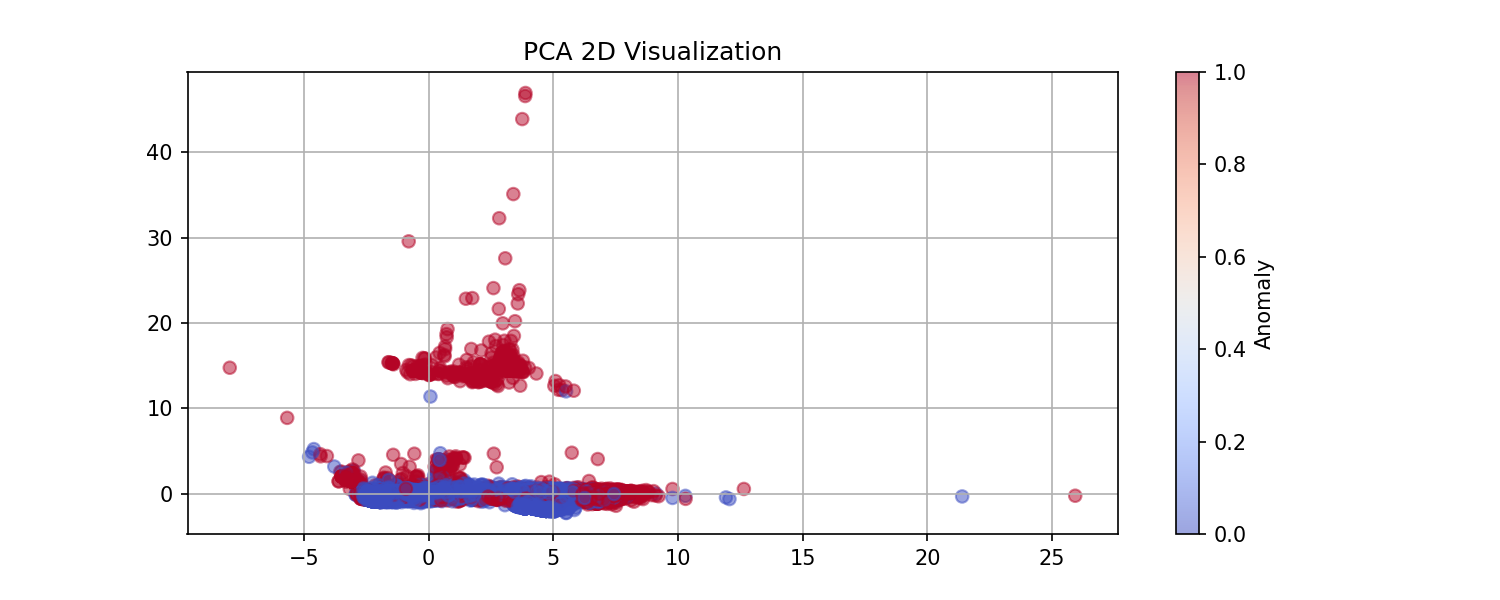

In [271]:
pca_2d = PCA(n_components=2)

X_pca = pca_2d.fit_transform(X)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Visualize in 2D
plt.figure(figsize=(10, 4))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=if_df['anomaly'], cmap='coolwarm', alpha=0.5)
plt.title('PCA 2D Visualization')
plt.colorbar(label='Anomaly')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


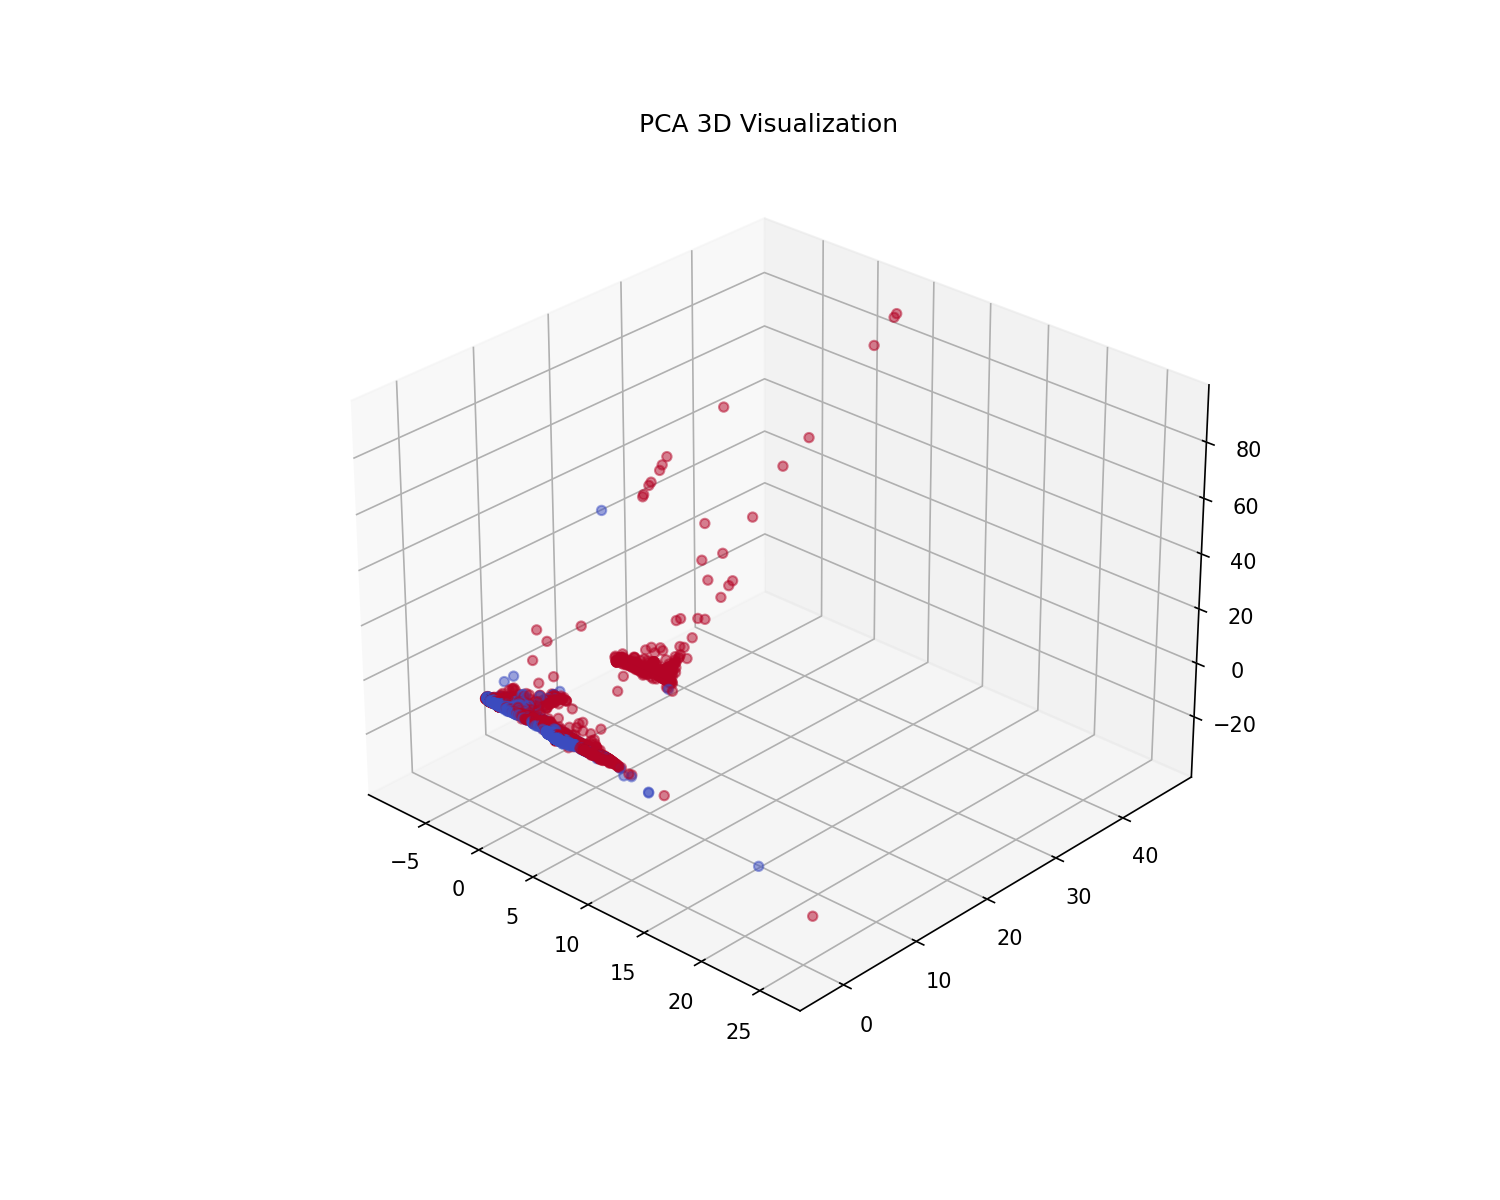

In [248]:
pca_3d = PCA(n_components=3)

X_pca_3d = pca_3d.fit_transform(X)

pca_df_3d = pd.DataFrame(data=X_pca_3d, columns=['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df_3d['PC1'], pca_df_3d['PC2'], pca_df_3d['PC3'], c=if_df['anomaly'], cmap='coolwarm', alpha=0.5)
ax.set_title('PCA 3D Visualization')
plt.show()


## Advance Models

---
>### 1. AE (AutoEndcoder)


In [566]:
ae_df = df.copy()
X = df_norm.iloc[:,3:]
# X.drop(columns=['response_length_avg' ,'response_time_avg'], inplace=True)

In [567]:
input_dim = X.shape[1]
encoding_dim = 32 
hidden_dim_1 = int(encoding_dim / 2)
hidden_dim_2 = int(hidden_dim_1 / 4)
hidden_dim_3 = int(hidden_dim_1 / 8)

#encode
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(hidden_dim_1, activation="relu")(encoder)
encoder = Dense(hidden_dim_2, activation="relu")(encoder)
#latent
latent_space = Dense(latent_dim, activation="relu")(encoder)
#decode
decoder = Dense(hidden_dim_2, activation="relu")(latent_space)
decoder = Dense(hidden_dim_1, activation="relu")(decoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
output_layer = Dense(input_dim, activation="sigmoid")(decoder)



autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder.fit(X, X, epochs=100, batch_size=256, shuffle=True, validation_split=0.3, verbose=0)

<IPython.core.display.Javascript object>


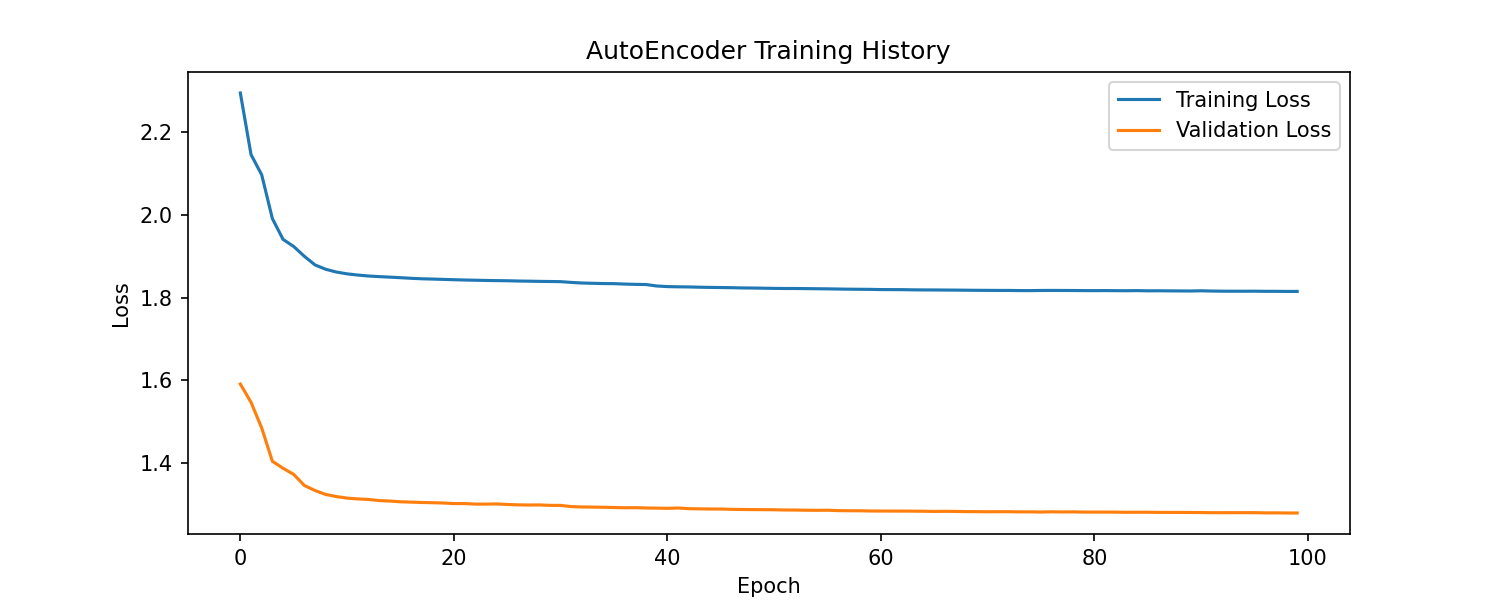

In [568]:
# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('AutoEncoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [569]:
reconstructions = autoencoder.predict(X)
mse = np.mean(np.power(X - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 94) 

#anomalies
anomalies = mse > threshold
ae_df['anomaly_score'] = mse
ae_df['anomaly'] = anomalies

# Summary of anomalies
print(f"Number of anomalies: {np.sum(anomalies)}")
print(f"Total instances: {len(X)}")
print(f"Anomaly percentage: {np.sum(anomalies) / len(X) * 100:.2f}%")

1043/1043 [==============================] - 1s 683us/step
Number of anomalies: 2001
Total instances: 33346
Anomaly percentage: 6.00%


In [570]:
is_bot = ae_df[ae_df['is_bot'] == 1]

bot_anomaly_count = len(is_bot[is_bot['anomaly'] == True])
bot_non_anomaly_count = len(is_bot[is_bot['anomaly'] == False])

# Print the results
print("Number of anomalies with is_bot:", bot_anomaly_count)
print("Number of non-anomalies with is_bot:", bot_non_anomaly_count)


Number of anomalies with is_bot: 669
Number of non-anomalies with is_bot: 0


In [571]:
anomalies_df = ae_df[ae_df['anomaly'] == True]
anomalies_df.sort_values(['anomaly_score'], ascending=False).head(30)

,ip,user_agent,request_count,crawled_rate_avg,Head_request_avg,url_anomaly_rate_avg,url_path_depth_avg,image_request_avg,code_request_avg,renderable_request_avg,...,3xx_avg,response_length_bin_avg,response_time_bin_avg,response_length_avg,response_time_avg,response_length_bin_std,response_time_bin_std,is_bot,anomaly_score,anomaly
3957,14.226.145.71,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,15,0.056948,0.000000,0.020000,3.666667,0.266667,0.000000,0.066667,...,0.000000,2.400000,0.466667,9.709612e+06,7.069333e+02,1.298351,0.639940,0,2617.400770,True
31550,78.157.60.161,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:8...,26,0.044078,0.000000,0.030769,1.692308,0.346154,0.192308,0.038462,...,0.000000,1.269231,0.269231,1.920454e+04,6.736321e+06,1.002305,0.961569,0,1419.922508,True
9109,207.213.207.102,Googlebot-Image/1.0,23625,0.160696,0.000000,0.002502,2.900614,0.050878,0.000000,0.000000,...,0.000000,0.015577,0.013291,2.827268e+02,2.114506e+01,0.188820,0.114520,1,952.508854,True
9116,207.213.207.116,Googlebot-Image/1.0,23379,0.158689,0.000000,0.002669,2.902092,0.050387,0.000000,0.000000,...,0.000000,0.014885,0.012618,2.699742e+02,2.116091e+01,0.184155,0.111622,1,932.856480,True
8571,20.163.161.41,Mozilla/5.0 (iPhone; CPU iPhone OS 7_0 like Ma...,35,0.381179,0.714286,0.017143,2.142857,0.314286,0.114286,0.000000,...,0.000000,0.600000,0.114286,3.742854e+04,1.858286e+02,1.090062,0.403764,0,890.186388,True
9121,207.213.207.130,Googlebot-Image/1.0,21494,0.150491,0.000000,0.002135,2.901787,0.050386,0.000000,0.000000,...,0.000000,0.013818,0.013073,3.106020e+02,2.132130e+01,0.179809,0.113592,1,789.116982,True
8901,20.92.247.146,sentry/21.4.1 (https://sentry.io),19462,0.213458,0.000000,0.004116,1.001285,0.000000,0.999024,0.000000,...,0.000000,2.999281,0.399702,9.286983e+05,4.402651e+01,0.026812,0.489850,0,646.179282,True
9202,207.213.57.238,Mozilla/5.0 (Linux; Android 7.0; SM-G930V Buil...,5,0.075460,0.000000,0.000000,2.000000,0.000000,0.200000,0.000000,...,0.000000,2.600000,0.600000,6.017557e+06,4.504000e+02,0.894427,0.894427,0,592.233981,True
25281,36.67.23.210,Go-http-client/2.0,7580,0.434183,0.458179,0.000000,0.886412,0.000000,0.000000,0.346570,...,0.097493,0.542084,0.023219,6.610200e+03,1.683720e+01,0.666185,0.150608,0,464.168022,True
2034,123.17.167.222,MBCrawler/1.0 (https://monitorbacklinks.com/ro...,4,0.405362,0.500000,0.000000,2.000000,0.000000,0.000000,0.500000,...,0.000000,1.000000,0.000000,1.300450e+04,9.000000e+00,1.154701,0.000000,1,464.095665,True


In [572]:
anomalies_df['anomaly_score'].min()

2.647797388227822

In [573]:
anomalies_df[anomalies_df['user_agent'].str.contains('blackberry', case=False)]

,ip,user_agent,request_count,crawled_rate_avg,Head_request_avg,url_anomaly_rate_avg,url_path_depth_avg,image_request_avg,code_request_avg,renderable_request_avg,...,3xx_avg,response_length_bin_avg,response_time_bin_avg,response_length_avg,response_time_avg,response_length_bin_std,response_time_bin_std,is_bot,anomaly_score,anomaly
5917,14.9.86.233,Mozilla/5.0 (BlackBerry; U; BlackBerry 9900; e...,117,0.023185,0.0,0.193162,1.205128,0.495726,0.034188,0.0,...,0.008547,1.017094,0.017094,23300.461538,207.0,1.033765,0.1849,0,2.650439,True


In [574]:
anomalies_df[anomalies_df['user_agent'].str.contains('python', case=False)]

,ip,user_agent,request_count,crawled_rate_avg,Head_request_avg,url_anomaly_rate_avg,url_path_depth_avg,image_request_avg,code_request_avg,renderable_request_avg,...,3xx_avg,response_length_bin_avg,response_time_bin_avg,response_length_avg,response_time_avg,response_length_bin_std,response_time_bin_std,is_bot,anomaly_score,anomaly
9294,21.101.108.189,python-requests/2.18.1,4,0.957375,0.0,0.0,0.75,0.0,0.0,0.0,...,0.25,1.5,0.0,47534.25,24.0,1.0,0.0,0,10.791418,True


In [575]:
anomalies_df[anomalies_df['user_agent'].str.contains('twitter', case=False)]


,ip,user_agent,request_count,crawled_rate_avg,Head_request_avg,url_anomaly_rate_avg,url_path_depth_avg,image_request_avg,code_request_avg,renderable_request_avg,...,3xx_avg,response_length_bin_avg,response_time_bin_avg,response_length_avg,response_time_avg,response_length_bin_std,response_time_bin_std,is_bot,anomaly_score,anomaly
1984,118.112.79.240,Twitterbot/1.0,4,0.608469,0.0,0.0,2.000000,0.000000,0.0,0.5,...,0.000000,2.000000,0.250000,22326.250000,39.000000,0.000000,0.500000,1,36.650427,True
1985,118.112.79.6,Twitterbot/1.0,4,0.691907,0.0,0.0,2.000000,0.000000,0.0,0.5,...,0.000000,2.250000,0.000000,71377.000000,18.000000,0.500000,0.000000,1,36.611878,True
2788,127.227.127.114,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,6,0.013897,0.0,0.0,1.666667,0.666667,0.0,0.0,...,0.000000,2.166667,0.000000,46211.000000,11.333333,0.408248,0.000000,1,17.642580,True
2945,127.227.194.30,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,4,0.775679,0.0,0.0,1.000000,1.000000,0.0,0.0,...,0.000000,2.000000,0.000000,28253.000000,4.000000,0.000000,0.000000,1,27.392461,True
2974,127.227.205.56,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,12,0.038611,0.0,0.0,1.583333,0.916667,0.0,0.0,...,0.000000,2.000000,0.000000,26133.500000,9.666667,0.000000,0.000000,1,13.568945,True
3158,127.227.6.81,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,6,0.495068,0.0,0.0,1.500000,0.666667,0.0,0.0,...,0.166667,1.833333,0.000000,34504.000000,13.333333,0.408248,0.000000,1,17.767673,True
6303,141.5.60.35,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,12,0.007130,0.0,0.0,1.500000,0.916667,0.0,0.0,...,0.000000,2.000000,0.000000,25814.083333,7.000000,0.000000,0.000000,1,13.586750,True
10472,228.196.120.81,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,6,0.056948,0.0,0.0,1.666667,0.666667,0.0,0.0,...,0.000000,2.166667,0.166667,53443.333333,14.666667,0.408248,0.408248,1,17.449130,True
11424,29.240.244.96,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,8,0.038611,0.0,0.0,1.000000,1.000000,0.0,0.0,...,0.000000,2.000000,0.000000,28253.000000,3.000000,0.000000,0.000000,1,27.256070,True
12602,35.109.51.66,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...,13,0.022380,0.0,0.0,1.615385,0.846154,0.0,0.0,...,0.076923,1.923077,0.000000,24133.000000,9.538462,0.277350,0.000000,1,13.481149,True


1043/1043 [==============================] - 1s 593us/step


<IPython.core.display.Javascript object>


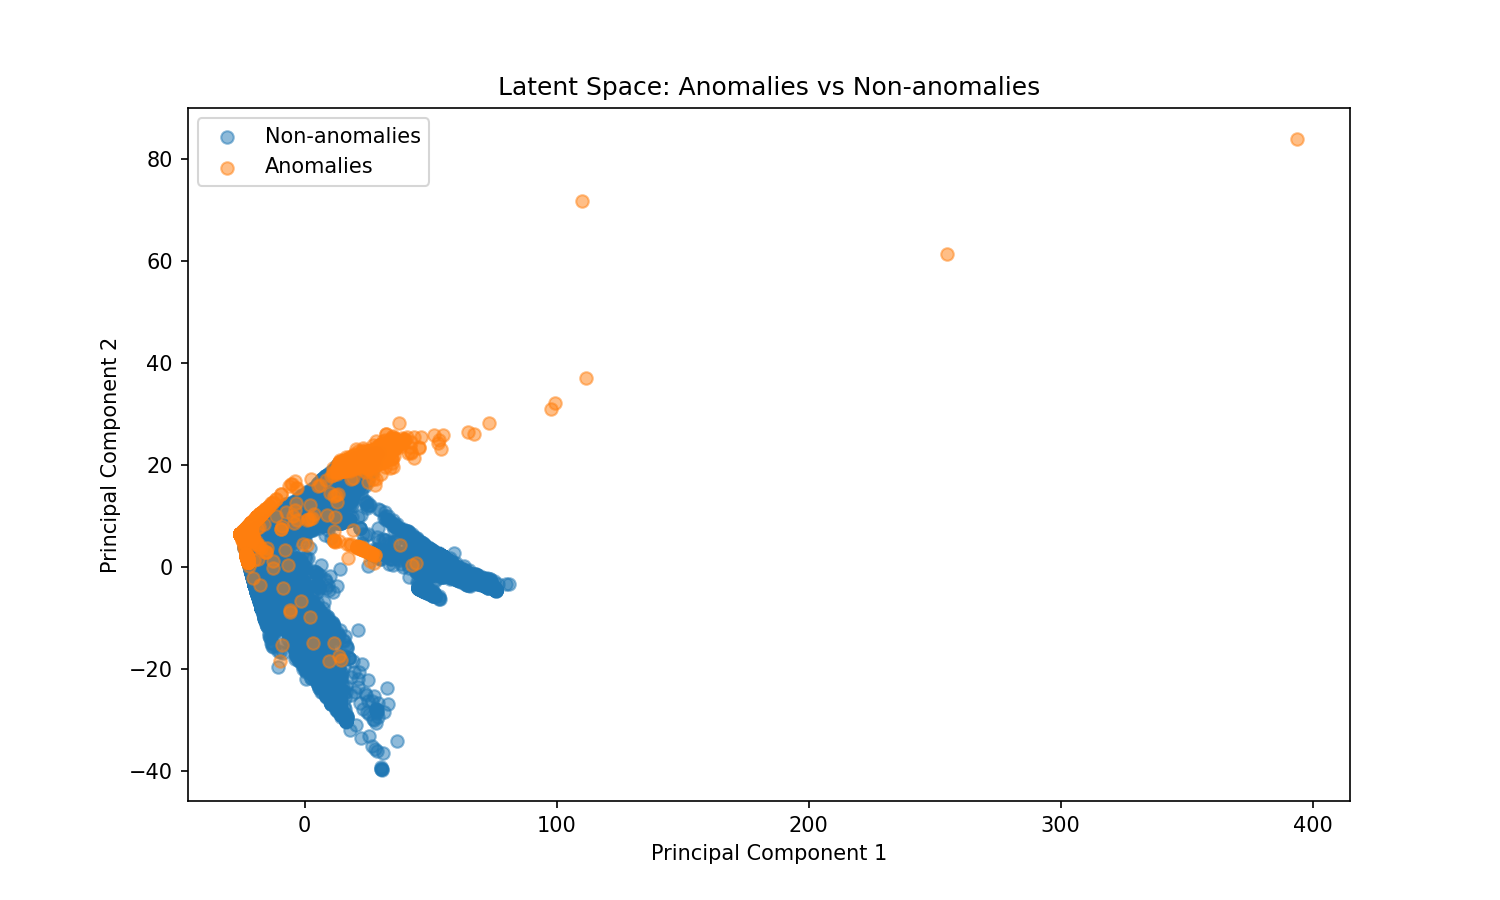

In [582]:
# Extract latent space representations
encoder_model = Model(inputs=input_layer, outputs=latent_space)
latent_representations = encoder_model.predict(X)

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations)

anomalies = ae_df['anomaly'].values
plt.figure(figsize=(10, 6))
plt.scatter(latent_2d[~anomalies, 0], latent_2d[~anomalies, 1], label='Non-anomalies', alpha=0.5)
plt.scatter(latent_2d[anomalies, 0], latent_2d[anomalies, 1], label='Anomalies', alpha=0.5)
plt.title('Latent Space: Anomalies vs Non-anomalies')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

---
>### 2. VAE (VariationalAutoEndcoder)


the auto encoder is good enough but if we want to see better visualization in latent space for anomaly vs non anomaly we can implemet it  too.